<a href="https://colab.research.google.com/github/lschulte19/valida-o_dados/blob/main/Projeto_Valida%C3%A7%C3%A3o_de_modelos_de_clusteriza%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#Biblioteca que vamos usar nesse projeto
from google.colab import drive
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score


print("Essa é a versão do Python")
print(sys.version)

Essa é a versão do Python
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


Nesse item importamos as bibliotecas que iremos usar no projeto final

No dataset escolhido temos segmentação de compra de clientes, temos os seguintes dados dos clientes.

ID: Identificador de cada cliente
Sex: 0 masculino e 1 feminino
Maritial: 0 solteiro(a) e 1 casado(a), divorciado(a), viuvo(a) e etc
Age: Idade
Education: 0 desconhecido, 1 ensino médio, 2 superior, 3 pos-graduação
Income: Renda anual autodeclarada em dólares americanos do cliente
Occupation: 0 desempregado, 1 funcionário qualificado e 2 gerência / autônomo / funcionário altamente qualificado / oficial
Settlement size: Tamno a cidade que o cliente vive, 0 cidade pequena, 1 média e 2 grande

Nesse dataset como são informações reais e anonimizados podemos fazer um estudo de segmentação de mercado para esses clientes, por exemplo:


**Baseado na renda e idad**e
Usar Income e Age permite criar grupos baseados em ciclos de vida (jovens com baixa renda, adultos com alta renda, etc.).
Ideal para estratégias de marketing ou análise de consumo.

**Baseado em localização e renda**
Usar Settlement size e Income pode revelar diferenças regionais nos padrões econômicos.
Útil para estratégias de expansão geográfica ou políticas regionais

**Baseado no sexo e estado civil**
Agrupar por Sex e Marital status pode ser útil para entender como gênero e estado civil influenciam o comportamento de consumo.
Interessante para campanhas específicas.

Vamos fazer um estudo baseado no sexo e idade

In [23]:
# prompt: montar dois arquivos do drive aqui no colab

from google.colab import drive
drive.mount('/content/drive')
# Example: Accessing a specific file
with open('/content/drive/My Drive/segmentation data.csv', 'r') as f:
   file_contents = f.read()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Com o dataset já importado vamos começar a analisar os dados, primeiro vamos dar um df e depois plotar a renda de todo o conjunto

In [24]:
df = pd.read_csv('/content/drive/My Drive/segmentation data.csv')
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


<ipython-input-25-b315101a54e0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Income'])


<Axes: xlabel='Income', ylabel='Density'>

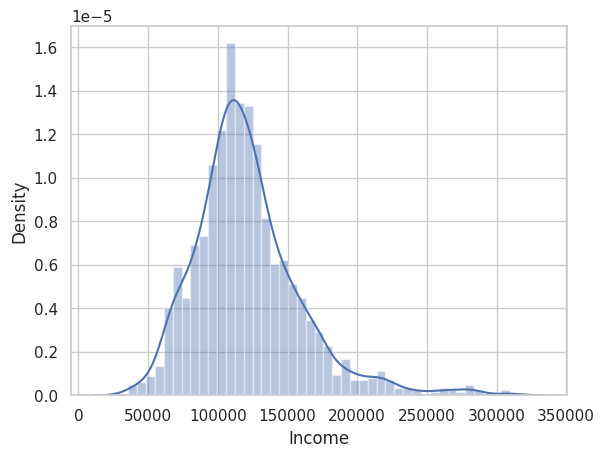

In [25]:
#Vamos plotar para ver a distribuição da renda do nosso dataset (Income)
sns.distplot(df['Income'])

<ipython-input-26-d5e1585b4064>:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


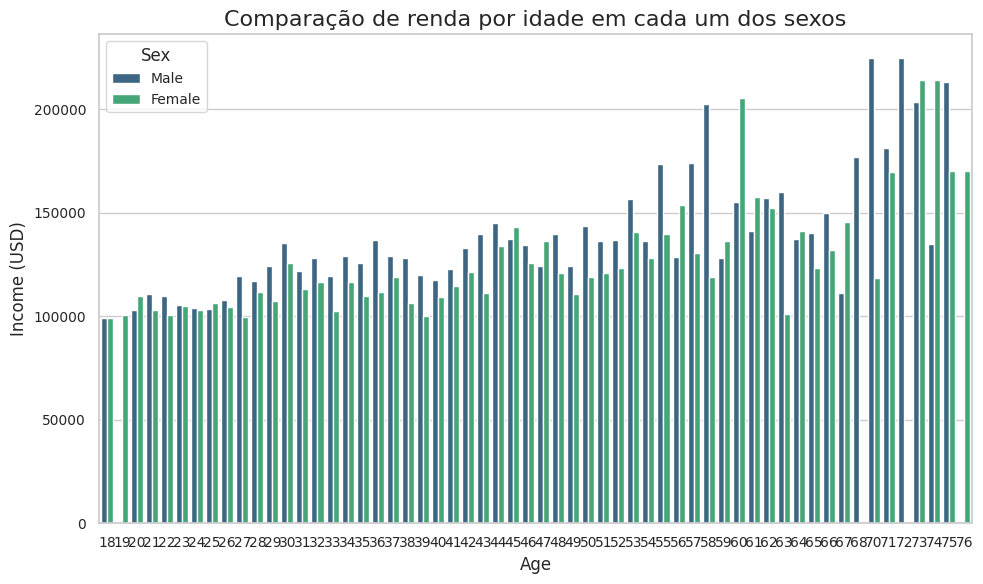

In [26]:
df['Sex'] = df['Sex'].map({0: 'Male', 1: 'Female'})
df['Marital status'] = df['Marital status'].map({0: 'Single', 1: 'Married/Other'})

# Configurando o estilo do Seaborn
sns.set(style="whitegrid")

# Criando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x='Age',
    y='Income',
    hue='Sex',
    palette='viridis',
    ci=None
)

# Ajustando o gráfico
plt.title('Comparação de renda por idade em cada um dos sexos', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Income (USD)', fontsize=12)
plt.legend(title='Sex', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [38]:
# Calculando a faixa dinâmica (range) para as colunas 'Income' e 'Age'
income_range = df['Income'].max() - df['Income'].min()
age_range = df['Age'].max() - df['Age'].min()
print(f"Faixa dinâmica de Income (homens e mulheres): {income_range}")
print(f"Faixa dinâmica de Age (homens e mulheres): {age_range}")

Faixa dinâmica de Income (homens e mulheres): 273532
Faixa dinâmica de Age (homens e mulheres): 58


<ipython-input-28-726b49f0e7a4>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df.groupby(['Sex', 'Marital status'], group_keys=False).apply(remove_outliers)
<ipython-input-28-726b49f0e7a4>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


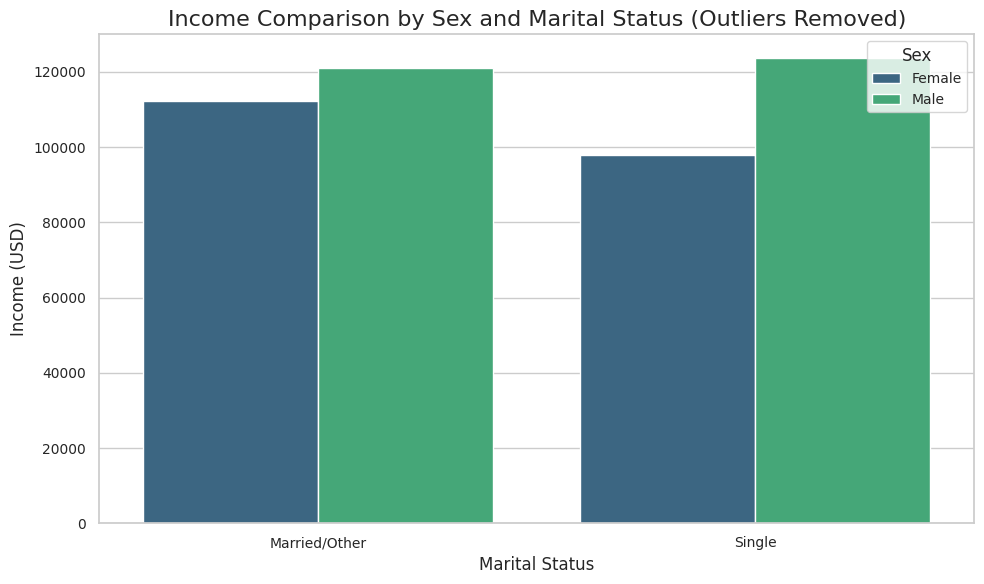

In [28]:
# Vamos remover os Outliers

# Removendo outliers por grupo (Sex e Marital status)
def remove_outliers(group):
    q1 = group['Income'].quantile(0.25)
    q3 = group['Income'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return group[(group['Income'] >= lower_bound) & (group['Income'] <= upper_bound)]

df_cleaned = df.groupby(['Sex', 'Marital status'], group_keys=False).apply(remove_outliers)

# Configurando o estilo do Seaborn
sns.set(style="whitegrid")

# Criando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_cleaned,
    x='Marital status',
    y='Income',
    hue='Sex',
    palette='viridis',
    ci=None
)

# Ajustando o gráfico
plt.title('Income Comparison by Sex and Marital Status (Outliers Removed)', fontsize=16)
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Income (USD)', fontsize=12)
plt.legend(title='Sex', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

<ipython-input-29-48a71d853e30>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.fit_predict(data[['Income']])
<ipython-input-29-48a71d853e30>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.fit_predict(data[['Income']])


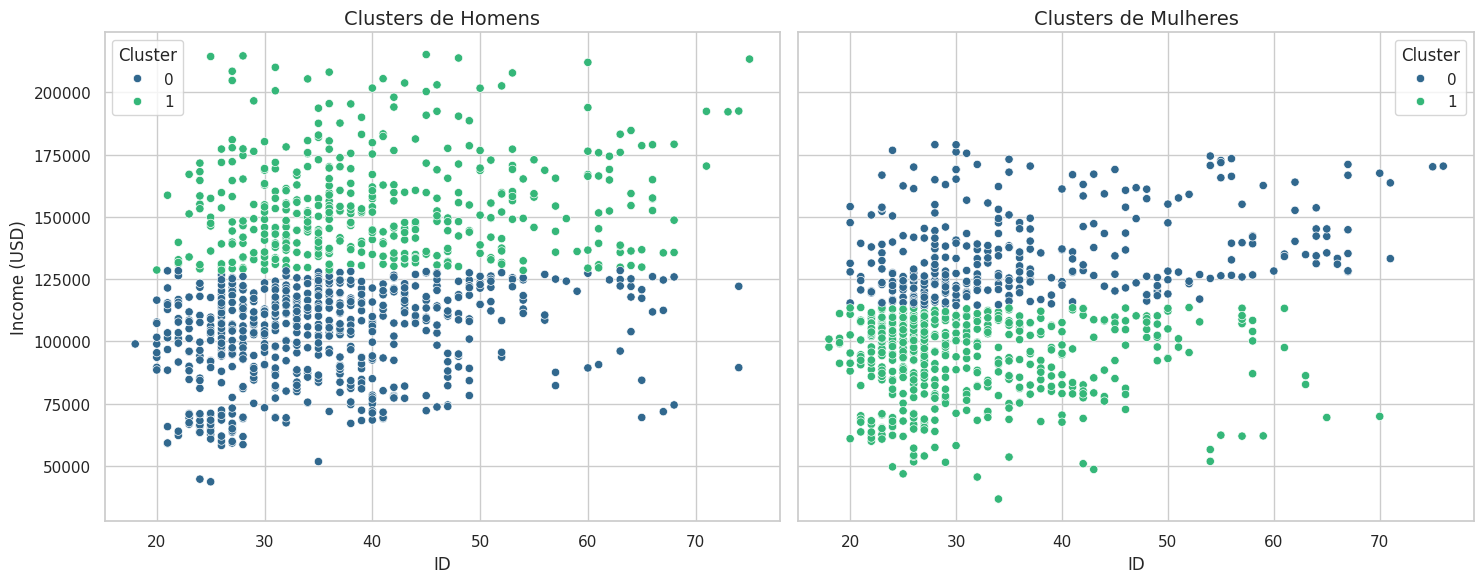

In [29]:
# Função para realizar clusterização por sexo
def perform_kmeans(data, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(data[['Income']])
    return data, kmeans

# Separando dados por sexo
male_data = df_cleaned[df_cleaned['Sex'] == 'Male']
female_data = df_cleaned[df_cleaned['Sex'] == 'Female']

# Aplicando K-Means para homens
male_clusters, male_kmeans = perform_kmeans(male_data)

# Aplicando K-Means para mulheres
female_clusters, female_kmeans = perform_kmeans(female_data)

# Configurando o estilo do Seaborn
sns.set(style="whitegrid")

# Criando gráficos para homens e mulheres
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Gráfico para homens
sns.scatterplot(
    data=male_clusters,
    x='Age',
    y='Income',
    hue='Cluster',
    palette='viridis',
    ax=axes[0]
)
axes[0].set_title('Clusters de Homens', fontsize=14)
axes[0].set_xlabel('ID', fontsize=12)
axes[0].set_ylabel('Income (USD)', fontsize=12)

# Gráfico para mulheres
sns.scatterplot(
    data=female_clusters,
    x='Age',
    y='Income',
    hue='Cluster',
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('Clusters de Mulheres', fontsize=14)
axes[1].set_xlabel('ID', fontsize=12)

# Ajustando layout
plt.tight_layout()
plt.show()

Silhouette Scores for Male:
Clusters: 2, Silhouette Score: 0.5524
Clusters: 3, Silhouette Score: 0.5558
Clusters: 4, Silhouette Score: 0.5463
Clusters: 5, Silhouette Score: 0.5377
Clusters: 6, Silhouette Score: 0.5420
Clusters: 7, Silhouette Score: 0.5419
Clusters: 8, Silhouette Score: 0.5468
Clusters: 9, Silhouette Score: 0.5435
Clusters: 10, Silhouette Score: 0.5265

Silhouette Scores for Female:
Clusters: 2, Silhouette Score: 0.5363
Clusters: 3, Silhouette Score: 0.5432
Clusters: 4, Silhouette Score: 0.5583
Clusters: 5, Silhouette Score: 0.5574
Clusters: 6, Silhouette Score: 0.5392
Clusters: 7, Silhouette Score: 0.5658
Clusters: 8, Silhouette Score: 0.5617
Clusters: 9, Silhouette Score: 0.5423
Clusters: 10, Silhouette Score: 0.5533


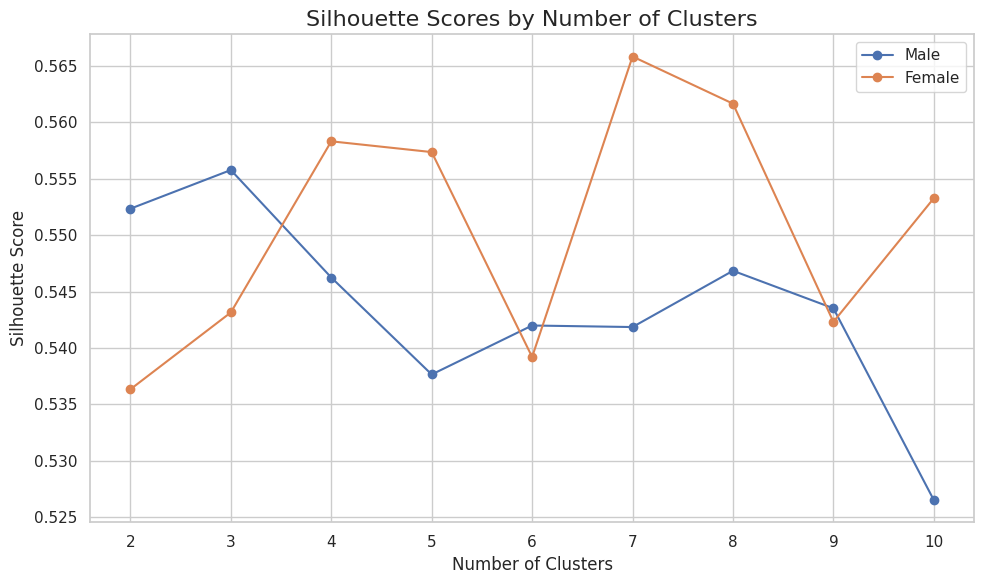

In [30]:
# Vamos gerar o indice de silhoute do k-means para ambos os conjuntos de dados

# Função para calcular o índice de silhueta
def calculate_silhouette(data, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data[['Income']])
        score = silhouette_score(data[['Income']], labels)
        silhouette_scores.append((n_clusters, score))
    return silhouette_scores


# Calculando o índice de silhueta para homens
male_silhouette = calculate_silhouette(male_data)

# Calculando o índice de silhueta para mulheres
female_silhouette = calculate_silhouette(female_data)

# Exibindo os resultados
print("Silhouette Scores for Male:")
for n_clusters, score in male_silhouette:
    print(f"Clusters: {n_clusters}, Silhouette Score: {score:.4f}")

print("\nSilhouette Scores for Female:")
for n_clusters, score in female_silhouette:
    print(f"Clusters: {n_clusters}, Silhouette Score: {score:.4f}")

# Visualizando os índices de silhueta
plt.figure(figsize=(10, 6))

# Para homens
male_clusters, male_scores = zip(*male_silhouette)
plt.plot(male_clusters, male_scores, label='Male', marker='o')

# Para mulheres
female_clusters, female_scores = zip(*female_silhouette)
plt.plot(female_clusters, female_scores, label='Female', marker='o')

plt.title('Silhouette Scores by Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Vimos que para mulher podemos ter 7 clusters, enquanto de homem esse valor é de 3 vamos ajustar o nosso k-means e ver como se comporta

O método de Silhueta determina o quão bem cada objeto está alocado em um grupo, ou seja, a homogeneidade de um grupo. O índice de Silhueta varia de -1 a 1. Valores próximos a 1 indicam que o objeto possui semelhança com objetos de seu grupo e dessemelhança com objetos de outros grupos. O seu processo de calculo do coeficiente é a distancia média de uma instancia de um grupo para todos os elementos do grupo próximo **(b**) menos a distancia média entre uma instancia do grupo para os outros elementos do mesmo grupo **(a)** dividio pelo maior valor de **a** e **b**

Formula
s = b - a / max (a,b)




<ipython-input-31-4013d09ebdfe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.fit_predict(data[['Income']])
<ipython-input-31-4013d09ebdfe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.fit_predict(data[['Income']])


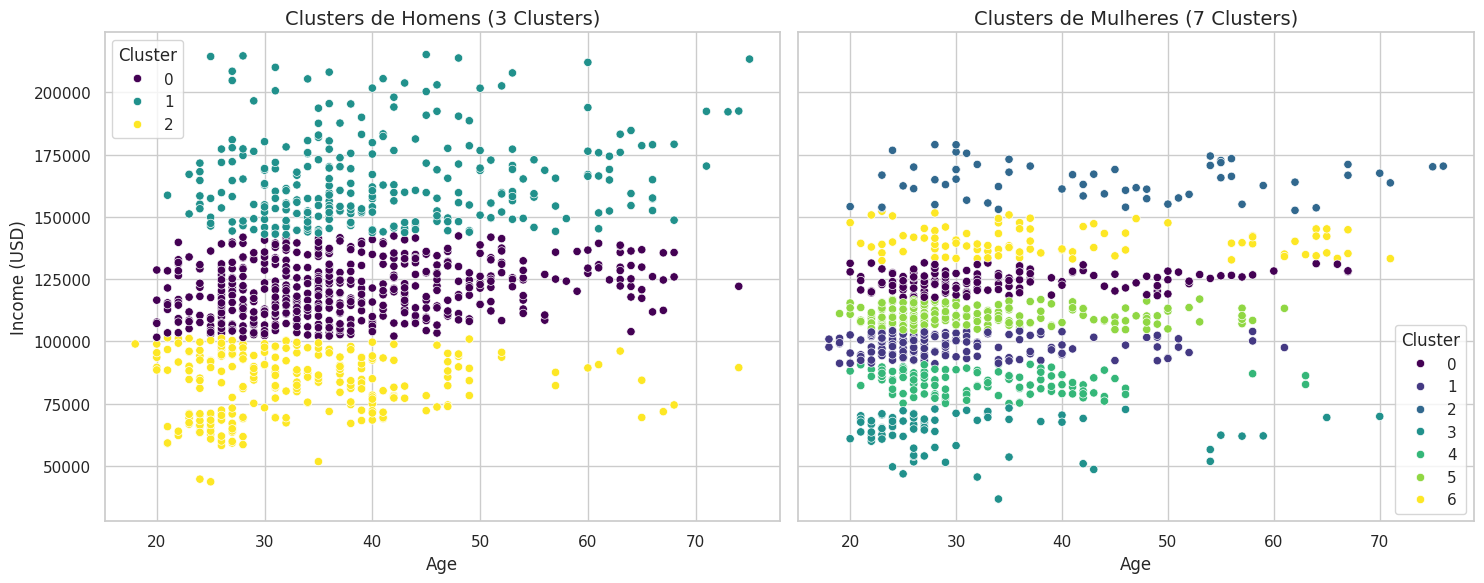

In [31]:
# Função para realizar o K-Means e adicionar os clusters
def perform_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(data[['Income']])
    return data, kmeans

# Separando dados por sexo
male_data = df_cleaned[df_cleaned['Sex'] == 'Male']
female_data = df_cleaned[df_cleaned['Sex'] == 'Female']

# Aplicando K-Means para homens com 3 clusters
male_clusters, male_kmeans = perform_kmeans(male_data, n_clusters=3)

# Aplicando K-Means para mulheres com 7 clusters
female_clusters, female_kmeans = perform_kmeans(female_data, n_clusters=7)

# Configurando o estilo do Seaborn
sns.set(style="whitegrid")

# Criando gráficos para homens e mulheres
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Gráfico para homens
sns.scatterplot(
    data=male_clusters,
    x='Age',
    y='Income',
    hue='Cluster',
    palette='viridis',
    ax=axes[0]
)
axes[0].set_title('Clusters de Homens (3 Clusters)', fontsize=14)
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Income (USD)', fontsize=12)

# Gráfico para mulheres
sns.scatterplot(
    data=female_clusters,
    x='Age',
    y='Income',
    hue='Cluster',
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('Clusters de Mulheres (7 Clusters)', fontsize=14)
axes[1].set_xlabel('Age', fontsize=12)

# Ajustando layout
plt.tight_layout()
plt.show()


Para o trabalho não ficar um grande usando sempre dados de homens e mulheres, vamos seguir apenas com cluster de mulheres. Vou ajustando o eps e mim_samples ir reduzindo a quantidade de cluster para o valor do indice da silueta que encontramos anterimormente

<ipython-input-32-a0d3a7ca8dc5>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df.groupby(['Sex', 'Marital status'], group_keys=False).apply(remove_outliers)
<ipython-input-32-a0d3a7ca8dc5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = dbscan.fit_predict(data[['Income']])


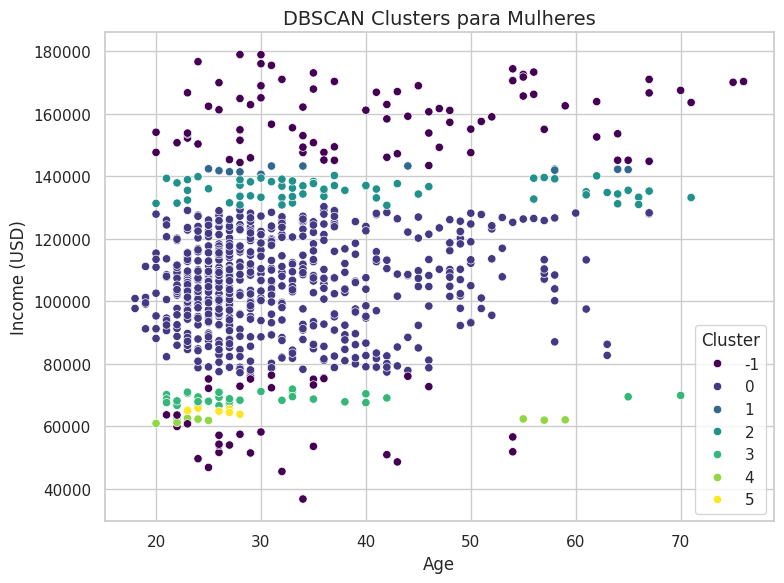

In [32]:

# Separando dados por sexo
df_cleaned = df.groupby(['Sex', 'Marital status'], group_keys=False).apply(remove_outliers)
female_data = df_cleaned[df_cleaned['Sex'] == 'Female']

# Aplicando DBSCAN para mulheres
def perform_dbscan(data, eps=0.2, min_samples=10):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    data['Cluster'] = dbscan.fit_predict(data[['Income']])
    return data, dbscan

# Executando DBSCAN para mulheres
female_clusters, female_dbscan = perform_dbscan(female_data, eps=1000, min_samples=10)

# Configurando o estilo do Seaborn
sns.set(style="whitegrid")

# Gráfico para mulheres com DBSCAN
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=female_clusters,
    x='Age',
    y='Income',
    hue='Cluster',
    palette='viridis',
    legend='full'
)
plt.title('DBSCAN Clusters para Mulheres', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Income (USD)', fontsize=12)
plt.tight_layout()
plt.show()

def calculate_silhouette(data):
    if len(set(data['Cluster'])) > 1 and -1 not in set(data['Cluster']):
        score = silhouette_score(data[['Income']], data['Cluster'])
        print(f"Índice de Silhueta: {score:.4f}")
        return score
    else:
        print("Índice de Silhueta não pode ser calculado devido a clusters insuficientes ou presença de ruído.")
        return None

Analisando os dois clusters (kmens x dbscan), percebemos que no k-means os clusters ficaram mais homogêneos, como se tivesse uma régua separando cada clusters e podendo ver claramente os agrupamentos.

Já o DBscan se formou um cluster grande (cluster 0) e seu separação não foi tão bem definida quanto o do k-means.

Já as semelhanças foram os agrupamentos ficaram quase na mesma faixa (Income x Age)

In [33]:
#Vamos ver outros indices de validação e comparar com o da silhueta, vamos primeira fazer a curva de elbow

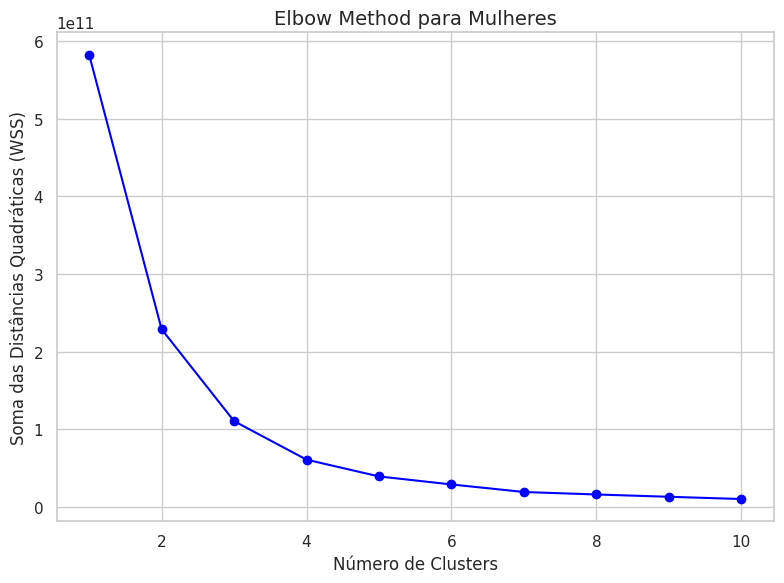

In [34]:
from sklearn.cluster import KMeans

female_data = df_cleaned[df_cleaned['Sex'] == 'Female']

# Método do cotovelo (Elbow Method)
def calculate_elbow(data, max_clusters=10):
    wss = []
    cluster_range = range(1, max_clusters + 1)
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data[['Income']])
        wss.append(kmeans.inertia_)

    # Plotando o gráfico do Elbow Method
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, wss, marker='o', linestyle='-', color='blue')
    plt.title('Elbow Method para Mulheres', fontsize=14)
    plt.xlabel('Número de Clusters', fontsize=12)
    plt.ylabel('Soma das Distâncias Quadráticas (WSS)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Aplicando o Elbow Method para mulheres
calculate_elbow(female_data)



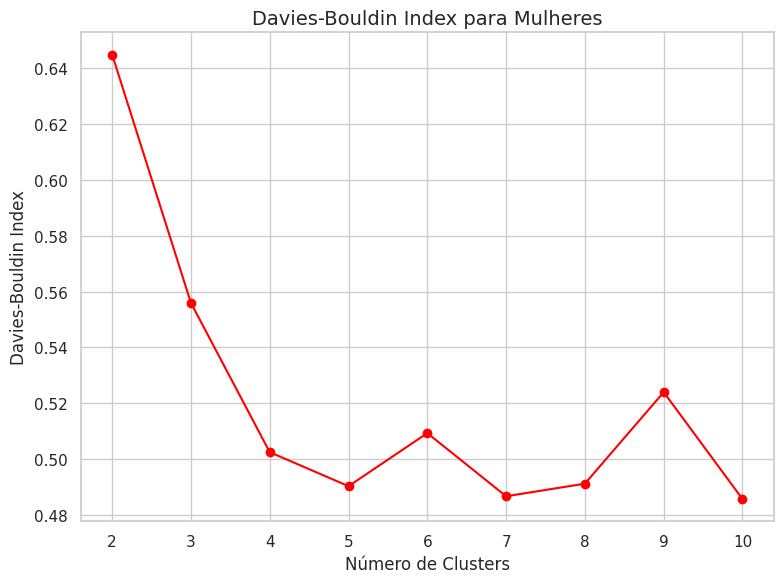

In [35]:
def calculate_davies_bouldin(data, max_clusters=10):
    db_scores = []
    cluster_range = range(2, max_clusters + 1)  # DBI requer pelo menos 2 clusters
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data[['Income']])
        score = davies_bouldin_score(data[['Income']], labels)
        db_scores.append((n_clusters, score))

    # Plotando o Davies-Bouldin Index
    plt.figure(figsize=(8, 6))
    clusters, scores = zip(*db_scores)
    plt.plot(clusters, scores, marker='o', linestyle='-', color='red')
    plt.title('Davies-Bouldin Index para Mulheres', fontsize=14)
    plt.xlabel('Número de Clusters', fontsize=12)
    plt.ylabel('Davies-Bouldin Index', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

calculate_davies_bouldin(female_data)


Podemos notar uma diferença entre os dois métodos, no elbow temos um decaindo e um ponto ótimo de 4~5 clusters, já no Davies-Bouldin o valor do cluster que tem o menor indice é o 7 o mesmo da silhueta

Realizando a análise, responda: A silhueta é um o índice indicado para escolher o número de clusters para o algoritmo de DBScan?
Não é o ideal para o dbscan, pois o dbscan tem caracteristica de encontrar clusters de densidade arbitraria e pode tambem identificar pontos de ruídos que não pertencem a nenhum cluster, já o indice de silhueta ele assume que todos os pontos pertencem a algum cluster, assim distorce os dados no dbscan.

# Medidas de similaridade


**Um determinado problema, apresenta 10 séries temporais distintas. Gostaríamos de agrupá-las em 3 grupos, de acordo com um critério de similaridade, baseado no valor máximo de correlação cruzada entre elas. Descreva em tópicos todos os passos necessários.**

R: Primeiramente temos que realizar o pré-processamento, assim temos que nos certificar que as séries temporais possuem o mesmo tamanho, fazendo uma normalizaão para padronizarmos para evitarmos que uma série "domine" as métricas de similaridade. Podemos tambem remover os outliers (caso exista). Após o pré-processamento vamos fazer o calculo da correlação cruzada.

Agora no cálculo da correlaão cruzada, para cada série temporais, vamos calcular ass correlações para diferentes lags e vamos identificar o valor máximo de correlação, ou seja, o lag que oferece maior correlação

Após isso, vamos criar uma matriz de similaridade de cada elemento do valor máximo da correlação cruzada entre as séries. E depois disso podemos agrupar escolhendo um algoritmo de agrupamento (k-means, k-medoids, dbscan ou hierarquico)




# **Para o problema da questão anterior, indique qual algoritmo de clusterização você usaria. Justifique.**

R: Eu escolheria o k-medoids, pois como temos que ter 3 grupos o dbscan poderia descartar um ponto e teríamos que ajustar o eps e min_samples, e o k-means pode não capturar bem se as series temporais estiverem padrões diferentes e distintos. Já o k-medoids sempre usa um ponto como centroide, o que pode ser ótimo que já que não conhecemos a tendencia dessas séries temporais e é mais robusto a outliers.


# **Indique um caso de uso para essa solução projetada.**

R: Podemos usar para analiser consumo de energia em grandes estabelecimentos, como mercado, shooping, fábrica e etc. Podemos coletar dados dos sistemas de ilumincação, climatização, equipamentos e etc. Podemos agrupar cada um em padrões de uso semelhante permitindo identificar a ineficiencia e tomar a decisão de quais equiapemtos, lampadas e etc trocar para reduzir o consumo de luz e otimizar o consumo


# **Sugira outra estratégia para medir a similaridade entre séries temporais. Descreva em tópicos os passos necessários.**

R: Podemos usar o coeficiente de similaridade do cosseno, basicamente esse coeficiente mede o angulo entre dois vetores no espaço vetorial, e para series temporais cada área pode ser tratada como vetores. Logo podemos aplicar o coeficiente do cosseno para calcular o quão semelhantes são cada série temporal como o outro.